In [1]:
import os
os.chdir("../")
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import os.path as osp
from PIL import Image
import shutil
import cv2
from tqdm import tqdm

from tools.centernet_utils import centernet_det_decode, centernet_det_post_process
from tools.scopehead_utils import scopehead_det_decode
from src.factory.config_factory import cfg, show_configs, build_output
from tools.logger import setup_logger
from src.factory.graph_factory import GraphFactory
logger = setup_logger("./external/")

def to_pil(cv_img):
    img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
    return Image.fromarray(img)

In [2]:
cfg.merge_from_file("/home/acer/Documents/deep-learning-works/configs/shufflenetv2_scopehead_object_detection.yml")
cfg.APEX = False
cfg.DISTRIBUTED = False
cfg.IO = False

In [3]:
graph = GraphFactory.produce(cfg)
graph.load(cfg.RESUME)

2020-06-03 10:16:47,448 25206 base_graph.py INFO: Model Loaded Successfully


In [4]:
img_path = "/home/acer/Pictures/pedestrian.jpg"
img = Image.open(img_path)
feat = graph.inference(img)[(128,128)]

[ResizeKeepAspectRatio, Tensorize, Normalize]


In [ ]:
w, h = img.size
c = np.array([[w / 2., h / 2.]], dtype=np.float32)
s = np.array([max(h, w) * 1.0])
dets = scopehead_det_decode(feat['hm'], feat['wh'], reg=feat['reg'], K=30)
dets = dets.detach().cpu().numpy().reshape(1, -1, dets.shape[1])
dets_out = centernet_det_post_process(
    dets.copy(), 
    c, 
    s, 
    feat['hm'].shape[2], 
    feat['hm'].shape[3], 
    feat['hm'].shape[1]
)

In [103]:
w, h = img.size
c = np.array([[w / 2., h / 2.]], dtype=np.float32)
s = np.array([max(h, w) * 1.0])
dets = centernet_det_decode(feat['hm'], feat['wh'], reg=feat['reg'], K=30)
dets = dets.detach().cpu().numpy().reshape(1, -1, dets.shape[1])
dets_out = centernet_det_post_process(
    dets.copy(), 
    c, 
    s, 
    feat['hm'].shape[2], 
    feat['hm'].shape[3], 
    feat['hm'].shape[1]
)


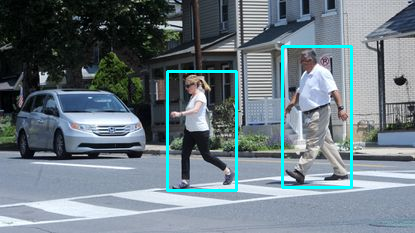

In [104]:
np_img = cv2.imread(img_path)
np_img = cv2.resize(np_img, (w, h))
num = 0
for c in dets_out[0]:
    for b in dets_out[0][c]:
        x1, y1, x2, y2, score = b
        if score >= 0.1:
            num += 1
            cv2.rectangle(np_img, (int(x1), int(y1)), (int(x2), int(y2)), (255,255,0), 2)
to_pil(np_img)

In [105]:
a = to_pil(np_img)

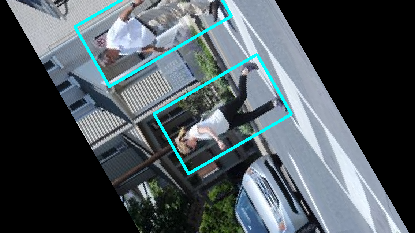

In [109]:
a.rotate(120)